In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import os

# Data exploration

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head() # 'PassengerId' is row number+1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# See missing values 
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Look at all Embarked labels
print("All 'Embarked' labels: ",train_data.Embarked.unique() )
print("Number of 'S': " ,np.sum(train_data.Embarked=='S') )
print("Number of 'C': " ,np.sum(train_data.Embarked=='C') )
print("Number of 'Q': " ,np.sum(train_data.Embarked=='Q') ) 

All 'Embarked' labels:  ['S' 'C' 'Q' nan]
Number of 'S':  644
Number of 'C':  168
Number of 'Q':  77


## Feature engineering with cabin data

In [5]:
# Get all unique cabins
unique_cabins = train_data.Cabin.unique()
print("All 'Cabin' labels: ",unique_cabins)

# Look at cabins with a certain first letter
c_cabins = [c for c in unique_cabins[1:] if c[0]=='C'] # [1:] skips nan
print("\n'Cabin' labels starting with 'C': ",c_cabins)

All 'Cabin' labels:  [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']

'Cabin' labels starti

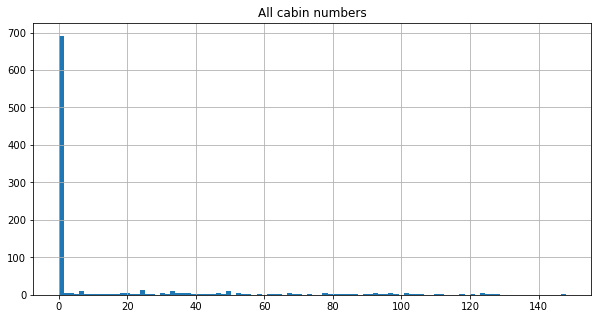

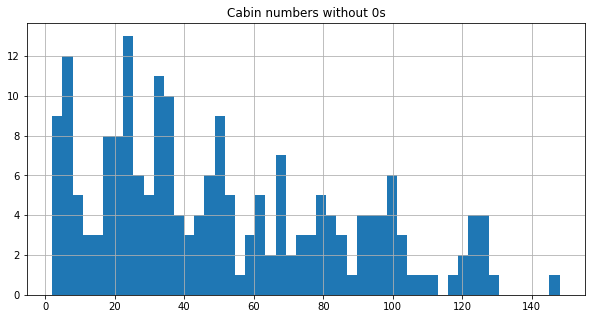

In [6]:
def get_cabin_numbers(df, nan_val=0):
    mean_cabin_numbers = []

    for cabin_codes in df.Cabin:

        # HOX! Some passengers had multiple cabins

        # If cabin code is nan set the number to 'nan_val' (=0)
        if cabin_codes is np.nan:
            cabin_number = nan_val
        else:
            
            # Get cabin numbers as a list
            cabin_numbers = []
            for cabin_code in cabin_codes.split(" "):
                cabin_number = ''.join([ c for c in cabin_code if c.isdigit() ])
                if cabin_number != '':
                    cabin_numbers.append(cabin_number)

            # Set the number to 0 if there wasn't any number, othervise calculate mean of cabin numbers in cabin_codes
            cabin_number = nan_val if (cabin_numbers == [''] or cabin_numbers == []) else np.array( cabin_numbers, dtype=np.int32).mean()

        # Append the cabin number
        mean_cabin_numbers.append( cabin_number )

    return np.array(mean_cabin_numbers)

# Get cabin numbers
mean_cabin_numbers = get_cabin_numbers(train_data)

# Plot
plt.figure(figsize=(10,5))
plt.hist( (mean_cabin_numbers), bins=100)
plt.title("All cabin numbers")
plt.grid()
plt.show() 

plt.figure(figsize=(10,5))
plt.hist( mean_cabin_numbers[np.where((mean_cabin_numbers)>0)], bins=50)
plt.title("Cabin numbers without 0s")
plt.grid()
plt.show() 

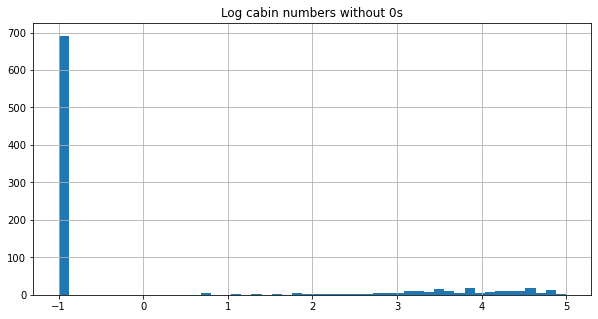

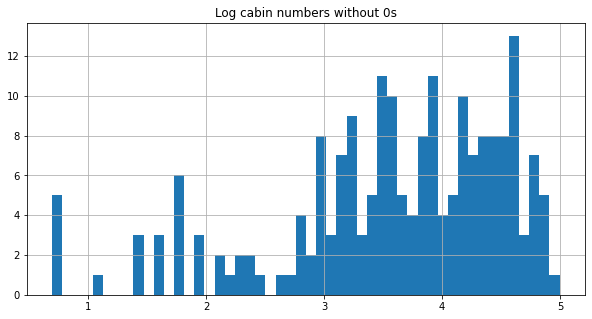

In [7]:
# Thinking about using log for numbers which had a cabin numbers and -1 for those that didn't, since log can't yield -1
plt.figure(figsize=(10,5))
plt.hist( np.where( mean_cabin_numbers>0, np.log(mean_cabin_numbers+0.01), -1), bins=50 ) # For some reason there are still 0s after the where '>0' filter so adding a +0.01
plt.title("Log cabin numbers without 0s")
plt.grid()
plt.show() 

# Started experimenting with log scaling after watching Ken Jee's video on this challenge https://www.youtube.com/watch?v=I3FBJdiExcg
plt.figure(figsize=(10,5))
plt.hist( np.log(mean_cabin_numbers[np.where((mean_cabin_numbers)>0)]), bins=50)
plt.title("Log cabin numbers without 0s")
plt.grid()
plt.show() 

In [8]:
alphabets = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','Y','Z']
all_decks = []

for alpha in alphabets:
    for cabin in train_data.Cabin.dropna():
        if alpha in cabin:
            all_decks.append(alpha)
            print(cabin)
            break
            
print(all_decks)

A6
B78
C85
D56
E46
F33
G6
T
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']


In [9]:
# Used for data transforms
def has_cabin_on_deck(df, deck_letter):
    # Returns a np array which has 1s at indices where there deck_letter was found and 0 otherwise 
    ret = np.zeros(df.Cabin.size)
    true_indices = [index for index, cabin in enumerate(df.Cabin) if deck_letter in str(cabin)] # str convert for nans, in is case sensitive ('a' of 'NaN' isn't the same as 'A') and there is no deck 'N' so this should be fine
    ret[true_indices] = 1
    return ret
    
print(has_cabin_on_deck(train_data, 'C')[:10])
print(train_data.Cabin[:10])

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object


## Feature engineering with ticket data

Number of unique tickets:  681
4 missing ticket number values, will be filled with mean


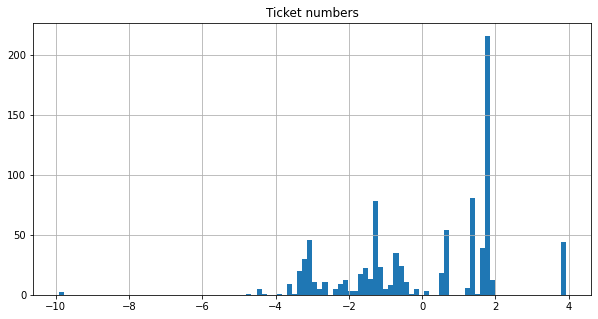

In [10]:
# Get all unique tickets
unique_tickets = train_data.Ticket.unique()
print("Number of unique tickets: ",len(unique_tickets))

def get_ticket_numbers(df):
    # Get ticket numbers
    ticket_numbers = np.zeros(df.shape[0])

    # Init dummy value 
    dummy_val = np.nan
    
    # Go through each ticket
    for index, t in enumerate(df.Ticket):
        ticket_number = ''
        for splitted in t.split(" "):        
            if splitted.isdigit():
                ticket_number = splitted
                break
                
        if ticket_number != '':
            ticket_numbers[index] = ticket_number
        else:
            ticket_numbers[index] = dummy_val
                
    print( np.isnan(ticket_numbers).sum(), "missing ticket number values, will be filled with mean")
                
    # Fill nans with the mean
    mean = np.mean( ticket_numbers[~np.isnan(ticket_numbers)] )
    ticket_numbers[np.isnan(ticket_numbers)] = mean
                
    return ticket_numbers

ticket_numbers = get_ticket_numbers(train_data)
    
log_ticket_numbers = np.log(ticket_numbers)
plt.figure(figsize=(10,5))
plt.hist( log_ticket_numbers-np.mean(log_ticket_numbers), bins=100)
plt.title("Ticket numbers")
plt.grid()
plt.show() 

# Looks like median would be a smarter fill value, due to the high frequency at some higher values

In [11]:
# Look at what kind of non numeric data is in the tickets
ticket_codes = []

# Go through each ticket
for t in train_data.Ticket:
    for splitted in t.split(" "):
        
        # If any of the sections in the data is not a digit, save it
        if not splitted.isdigit():
            ticket_codes.append(splitted)
            
ticket_codes = pd.Series(ticket_codes)
print("Total number of ticket codes: ",len(ticket_codes))
print(ticket_codes.value_counts())

# The usage of this data is left as an exercise for the reader ;D, 
# I wont be using this data now since there are so many missing values and unique values

Total number of ticket codes:  243
PC            60
C.A.          27
2.            12
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
A/5.           7
SOTON/OQ       7
STON/O2.       6
CA             6
F.C.C.         5
C              5
SC/PARIS       5
S.O.C.         5
SC/Paris       4
LINE           4
A/4            3
A/4.           3
S.O./P.P.      3
SC/AH          3
PP             3
A.5.           2
S.C./PARIS     2
SOTON/O2       2
P/PP           2
A./5.          2
WE/P           2
Basle          1
SO/C           1
S.W./PP        1
F.C.           1
A/S            1
SW/PP          1
SC             1
SCO/W          1
W.E.P.         1
W/C            1
Fa             1
S.O.P.         1
S.C./A.4.      1
A4.            1
S.P.           1
C.A./SOTON     1
dtype: int64


## Sex data

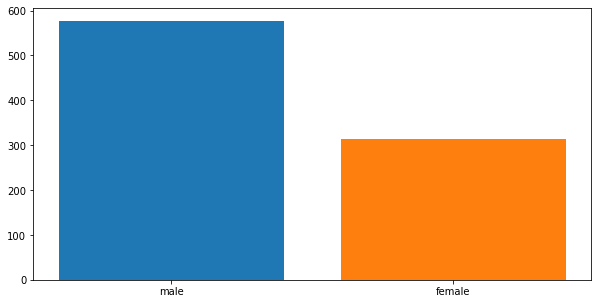

In [12]:
male_count   = np.sum(train_data.Sex=='male')
female_count = np.sum(train_data.Sex=='female')

plt.figure(figsize=(10,5))
# plt.hist(train_data.Pclass)
plt.bar(0, male_count)
plt.bar(1, female_count)
plt.xticks([0,1], ['male','female'])
plt.show()

## Age data

714  values in total


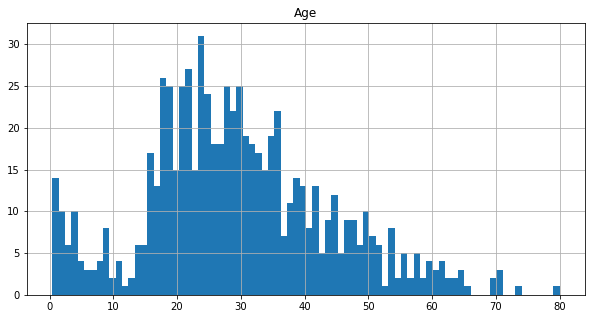

In [13]:
print(train_data.Age.dropna().size," values in total")

plt.figure(figsize=(10,5))
plt.hist(train_data.Age, bins=int(train_data.Age.max()))
plt.title("Age")
plt.grid()
plt.show() 

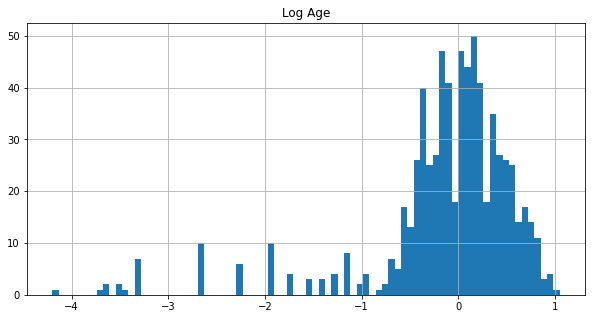

In [14]:
log_age = np.log(train_data.Age)

plt.figure(figsize=(10,5))
plt.hist( log_age-log_age.median(), bins=int(train_data.Age.max()))
plt.title("Log Age")
plt.grid()
plt.show()

# Log transform appears to make the data more normally distributed

## Fare data

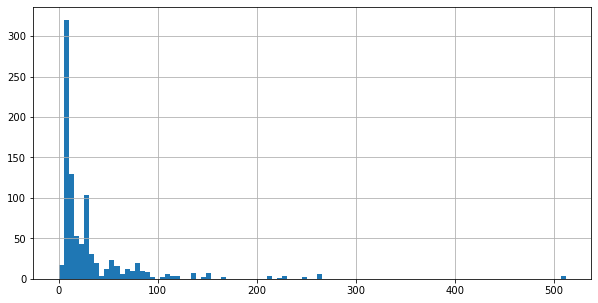

In [15]:
plt.figure(figsize=(10,5))
plt.hist(train_data.Fare, bins=100)
plt.grid()
plt.show()

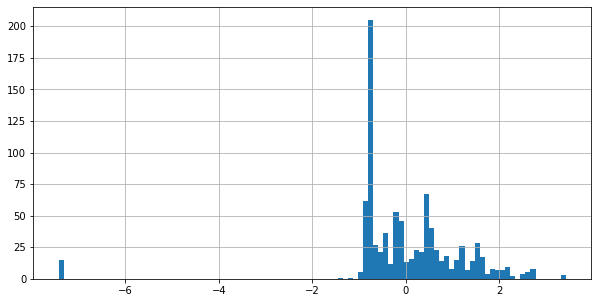

In [16]:
log_fare = np.log(train_data.Fare+0.01) # Someone's fare was 0, so adding 0.01 to be able to do the log transform

plt.figure(figsize=(10,5))
plt.hist(log_fare-log_fare.mean(), bins=100)
plt.grid()
plt.show()
# Log transform appears to make the data more normally distributed

## SibSp (siblings/spouses) data

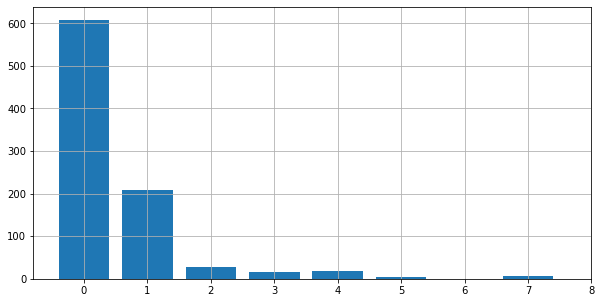

In [17]:
plt.figure(figsize=(10,5))
plt.hist(train_data.SibSp-0.4, bins=train_data.SibSp.max(), width=0.8)
plt.grid()
plt.show()

## Parch (parent/children) data

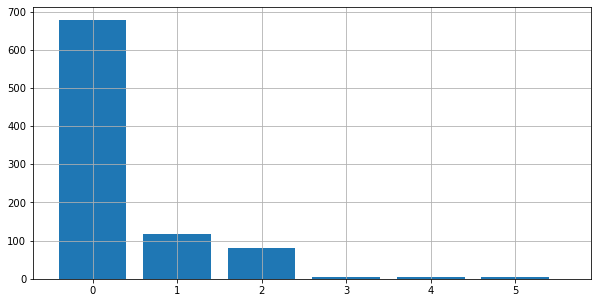

In [18]:
plt.figure(figsize=(10,5))
plt.hist(train_data.Parch-0.4, bins=train_data.Parch.max(), width=0.8)
plt.grid()
plt.show()

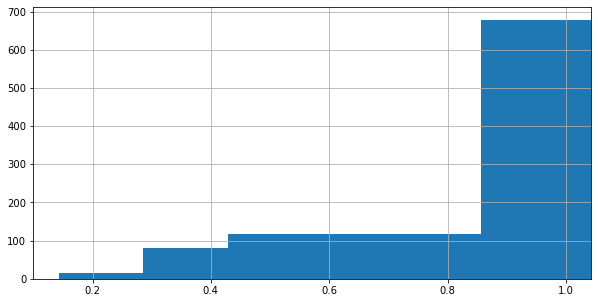

In [19]:
# Might try 1/(x+1) as a normalizing method some time
plt.figure(figsize=(10,5))
plt.hist( 1/(1+train_data.Parch), bins=train_data.Parch.max(), width=0.8)
plt.grid()
plt.show()

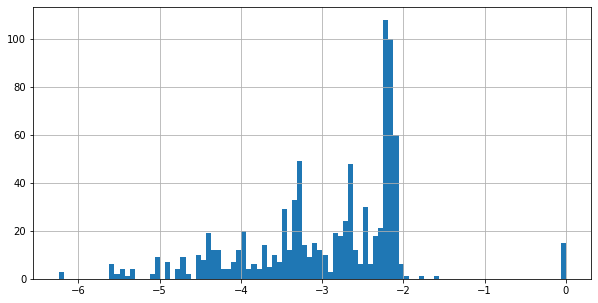

In [20]:
plt.figure(figsize=(10,5))
plt.hist(np.log( 1/(1+train_data.Fare) ), bins=100)
plt.grid()
plt.show()

## Name data

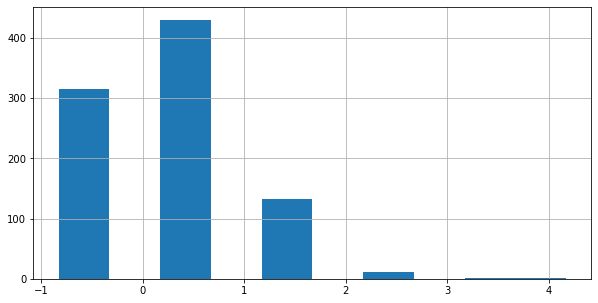

In [21]:
# Transform names to how many words are in them, excluding nicknames in "" and companions in ()
def get_name_lengths(df):
    return np.array( [ len( n.split('"')[0].split('(')[0].split(" ") ) for n in df.Name ] )

name_lengths = get_name_lengths(train_data)

plt.figure(figsize=(10,5))
plt.hist( (name_lengths-np.mean(name_lengths)) )
plt.grid()
plt.show()

# This might not be a good feature as royalty might have more names in general

# Transform data

In [22]:
# Make a DataFrame where each row is one nn input 
def transform_df(data_df, scaling_df, training=True):
    
    # Using separate 'data_df' and 'scaling_df'. In training the same df is used for both, but when testing 'data_df' is
    # the test data and 'scaling_df' is the training data. This is done to keep the input scaling the same for the nn.
    
    # I started experimenting with log scaling after watching Ken Jee's video on this challenge https://www.youtube.com/watch?v=I3FBJdiExcg
    
    # Initialize an empty dataframe
    transformed_df = pd.DataFrame()
    
    # Skip true labels for test data since there aren't any
    if training:
        transformed_df['survived']    = data_df.Survived # Target labels
        
    # TODO divide with std
        
    # Do data transforms
    transformed_df['in_class_1']      = np.where(data_df.Pclass==1, 1, 0) # One hot class
    transformed_df['in_class_2']      = np.where(data_df.Pclass==2, 1, 0) # One hot class
    transformed_df['in_class_3']      = np.where(data_df.Pclass==3, 1, 0) # One hot class
    transformed_df['sex']             = np.where(data_df.Sex=='male', 1, 0) # Binary activation
    transformed_df['sib_sp']          = data_df.SibSp/scaling_df.SibSp.max() # Normalized with scaling_df maximum
    transformed_df['parch']           = data_df.Parch/scaling_df.Parch.max() # Normalized with scaling_df maximum
    transformed_df['fare']            = np.log(data_df.Fare+0.01)-np.mean(np.log(scaling_df.Fare+0.01)) # Log scaled and mean shifted, see above data exploration on fare
    transformed_df['embarked_from_S'] = np.where(data_df.Embarked=='S', 1, 0) # One hot class, the 2 nan values will be [0,0,0]
    transformed_df['embarked_from_C'] = np.where(data_df.Embarked=='C', 1, 0) # One hot class
    transformed_df['embarked_from_Q'] = np.where(data_df.Embarked=='Q', 1, 0) # One hot class
    
    # New input values
    transformed_df['age']             = np.log(data_df.Age+0.01)-np.mean(np.log(scaling_df.Age+0.01)) # Log scaled and mean shifted (lead to all nans and this was a quick fix with minute chage), see above data exploration on age
    transformed_df['ticket_number']   = np.log(get_ticket_numbers(data_df))-np.mean(np.log(get_ticket_numbers(scaling_df))) # Log scaled and mean shifted, see above data exploration on ticket number
    
    # Cabin number, log where values were found and -1 otherwise
    cabin_numbers = np.log(get_cabin_numbers(data_df))
#     transformed_df['cabin_number'] = np.where( cabin_numbers>0, np.log(cabin_numbers+0.01), -1)
    transformed_df['cabin_number'] = np.where( cabin_numbers>0, np.log(cabin_numbers+0.01), np.nan) # Fill 0s (nans, see 'get_cabin_numbers') with nans which will be filled with the mean
    
    # All decks are ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    transformed_df['cabin_on_deck_A'] = has_cabin_on_deck(data_df, "A")
    transformed_df['cabin_on_deck_B'] = has_cabin_on_deck(data_df, "B")
    transformed_df['cabin_on_deck_C'] = has_cabin_on_deck(data_df, "C")
    transformed_df['cabin_on_deck_D'] = has_cabin_on_deck(data_df, "D")
    transformed_df['cabin_on_deck_E'] = has_cabin_on_deck(data_df, "E")
    transformed_df['cabin_on_deck_F'] = has_cabin_on_deck(data_df, "F")
    transformed_df['cabin_on_deck_G'] = has_cabin_on_deck(data_df, "G")
    transformed_df['cabin_on_deck_T'] = has_cabin_on_deck(data_df, "T")
    
    # Name length data
    transformed_df['name_length'] = get_name_lengths(data_df)-np.mean(get_name_lengths(scaling_df))
    
    # Family size, seemed important but simple to implement feature, ref: https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy 
    transformed_df['family_size'] = (data_df.SibSp + data_df.Parch + 1)/(scaling_df.SibSp + scaling_df.Parch + 1).max()
    
    # Go through columns and fill nan values with the mean of the column
    for c in transformed_df.columns:
        transformed_df[c].fillna(transformed_df[c].mean(), inplace=True)
    
    return transformed_df

# Get training data dataframe
nn_data = transform_df(train_data, train_data)
nn_data.head()

4 missing ticket number values, will be filled with mean
4 missing ticket number values, will be filled with mean


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


,survived,in_class_1,in_class_2,in_class_3,sex,sib_sp,parch,fare,embarked_from_S,embarked_from_C,...,cabin_on_deck_A,cabin_on_deck_B,cabin_on_deck_C,cabin_on_deck_D,cabin_on_deck_E,cabin_on_deck_F,cabin_on_deck_G,cabin_on_deck_T,name_length,family_size
0,0,0,0,1,1,0.125,0.0,-0.834657,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171717,0.181818
1,1,1,0,0,0,0.125,0.0,1.449766,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.171717,0.181818
2,1,0,0,1,0,0.000,0.0,-0.745753,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.828283,0.090909
3,1,1,0,0,0,0.125,0.0,1.155329,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.171717,0.181818
4,0,0,0,1,1,0.000,0.0,-0.730123,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171717,0.090909


# Build neural network

In [23]:
# Define device which net is trained on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# See if GPU ('cuda') is available
print(device)

cuda:0


In [24]:
# How many values are inputted to the neural net. -1 is for the target label
input_size = nn_data.shape[1]-1
hidden_size = 30
DROPOUT = 0.5

# Build neural net
model = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(DROPOUT),
    
            nn.Linear(hidden_size,hidden_size),
            nn.Sigmoid(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(DROPOUT),
    
            nn.Linear(hidden_size,hidden_size),
            nn.Sigmoid(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(DROPOUT),
    
            nn.Linear(hidden_size,hidden_size),
            nn.Sigmoid(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(DROPOUT),
    
            nn.Linear(hidden_size,1),
            nn.Sigmoid()
)

In [25]:
# Define model accuracy
torch_precision = torch.float64 # torch.float32 # 

# Set precision  
if torch_precision == torch.float32:
    model = model.float()
elif torch_precision == torch.float64:
    model = model.double()

# Set processing to device (cpu or gpu==cuda)
model = model.to(device)

# Initialize loss function and optimizer
criterion = nn.BCELoss()
learning_rate = 0.003 # 0.001 # Default lr, but it is nice to know where lr start since using a lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler reduces the learning rate on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=30, 
                                                       threshold=0.0001, 
                                                       threshold_mode='rel', 
                                                       cooldown=0, min_lr=learning_rate/40, 
                                                       eps=1e-08, 
                                                       verbose=True)

In [26]:
# Used to reset learning rate mid training
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
# Used for collecting lr which will be visualized in the loss plot 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Train neural network

Epoch 00144: reducing learning rate of group 0 to 1.5000e-03.
Epoch 00175: reducing learning rate of group 0 to 7.5000e-04.
Epoch 00292: reducing learning rate of group 0 to 3.7500e-04.
Epoch 00324: reducing learning rate of group 0 to 1.8750e-04.
Epoch 00355: reducing learning rate of group 0 to 9.3750e-05.
Epoch 00386: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00562: reducing learning rate of group 0 to 1.5000e-03.
Epoch 00593: reducing learning rate of group 0 to 7.5000e-04.
Epoch 00624: reducing learning rate of group 0 to 3.7500e-04.
Epoch 00655: reducing learning rate of group 0 to 1.8750e-04.
Epoch 00686: reducing learning rate of group 0 to 9.3750e-05.
Epoch 00717: reducing learning rate of group 0 to 7.5000e-05.
Epoch 01121: reducing learning rate of group 0 to 1.5000e-03.
Epoch 01152: reducing learning rate of group 0 to 7.5000e-04.
Epoch 01183: reducing learning rate of group 0 to 3.7500e-04.
Epoch 01245: reducing learning rate of group 0 to 1.8750e-04.
Epoch 01

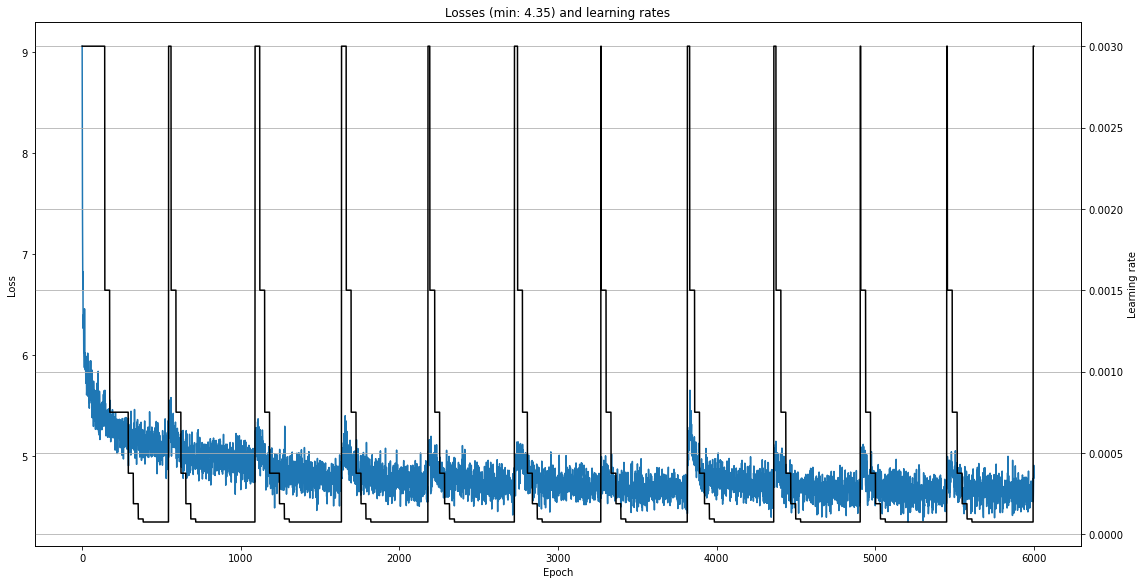

In [27]:
# Take all indices, mix them, and read them in batch size chunks. This way neural net data is mixed
num_indices = nn_data.shape[0]
indices = np.arange(num_indices)

# Training parameters
BATCH_SIZE = 64
EPOCHS = 6000
LEARNING_RATE_RESETS = 10

# List for training losses
training_losses = []

# Variable for lowest loss, used for saving the best parameters
lowest_loss = np.inf

# Collect learning rates
learning_rates = []

# Training loop
for epoch in range(EPOCHS):
    
    # Mix training data indices and zero loss of now starting epoch
    np.random.shuffle(indices)
    training_loss = 0
    model.train()
        
    # Training batch loop
    for ind in range(0, num_indices-BATCH_SIZE, BATCH_SIZE):

        # Get data from dataframe
        batch_indices = indices[ind:ind+BATCH_SIZE]
        data = nn_data.iloc[batch_indices]
        
        # TODO: keep nans up to this point and sample fill values for nans here. Since the data holds its own
        # distribution, sampling from it uniformly will yield samples from the desired distribution.
        
        # Move data to torch tenors
        target_labels = torch.tensor(data.survived.values, device=device, dtype=torch_precision).reshape(BATCH_SIZE,1)
        nn_input_data = torch.tensor(data.drop(['survived'],axis=1).values, device=device, dtype=torch_precision).reshape(BATCH_SIZE,input_size)

        # Do prediction with neural network forward pass
        pred = model(nn_input_data)
        
        # Evaluate performance
        loss = criterion(pred, target_labels)
        training_loss += loss.item()

        # Train the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Store the loss of epoch
    training_losses.append(training_loss)
    
    # If training loss has not decreased in 'patience' epochs, learning rate is decreased
    scheduler.step(training_loss) 
    
    # Save the parameters with the lowest loss
    if training_loss < lowest_loss:
        lowest_loss = training_loss
        torch.save(model.state_dict(), 'best_parameters.pt')

    # Reset learning rate LEARNING_RATE_RESETS times
    if epoch % int(EPOCHS/(LEARNING_RATE_RESETS+1)) == 0:
        set_lr(optimizer, learning_rate)
        
        # Load the parameters with lowest loss
        model.load_state_dict(torch.load('best_parameters.pt'))

    # Collect learning rate
    learning_rates.append(get_lr(optimizer))
        
# Plot losses
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(training_losses)

# Add learning rate on with second vertical axis
ax2 = ax1.twinx() 
ax2.set_ylabel('Learning rate') 
ax2.plot(learning_rates, 'k')
fig.tight_layout() 
plt.title(f'Losses (min: {lowest_loss:.2f}) and learning rates')
plt.grid()
plt.show()

In [28]:
# Read test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# Save passenger ids for submission
passenger_ids = test_data.PassengerId 

# Transform to neural net input scale, train_data is used for scaling
test_data = transform_df(test_data, train_data, training=False)

test_data.head()

0 missing ticket number values, will be filled with mean
4 missing ticket number values, will be filled with mean


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


,in_class_1,in_class_2,in_class_3,sex,sib_sp,parch,fare,embarked_from_S,embarked_from_C,embarked_from_Q,...,cabin_on_deck_A,cabin_on_deck_B,cabin_on_deck_C,cabin_on_deck_D,cabin_on_deck_E,cabin_on_deck_F,cabin_on_deck_G,cabin_on_deck_T,name_length,family_size
0,0,0,1,1,0.000,0.000000,-0.757900,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.828283,0.090909
1,0,0,1,0,0.125,0.000000,-0.869699,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171717,0.181818
2,0,1,0,1,0.000,0.000000,-0.545168,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171717,0.090909
3,0,0,1,1,0.000,0.000000,-0.656879,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.828283,0.090909
4,0,0,1,0,0.125,0.166667,-0.307640,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171717,0.272727


In [29]:
# Test data as a tensor
nn_input_test_data = torch.tensor(test_data.values, device=device, dtype=torch_precision).reshape(-1,input_size)

# Load the parameters with lowest loss
model.load_state_dict(torch.load('best_parameters.pt'))

# Do prediction on test data. 'eval' omits dropouts and no grad skips gradient calculation used for training the net
model.eval()
with torch.no_grad():
    test_data_pred = model(nn_input_test_data).squeeze()
    test_data_pred_int = test_data_pred.round().to(torch.int64)

# Save submission to csv
submission = pd.DataFrame()
submission['PassengerId'] = passenger_ids
submission['Survived'] = test_data_pred_int.cpu().numpy()
submission.to_csv('dense_net_with_feature_engineering_submission6.csv', index=False)

# Look at head of submission
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
